# Multiomics BRDC Paper — Figure 5

This Jupyter Notebook (with Python 3 kernel) contained the code of the proteogenomic analysis including 4 clinical subtypes (LuminalA, LuminalB, Her2-enriched, and TNBC) of IDC, and DCIS_Pro-IDC pair-wised progression.

Input files:
* The clinical file: clinical.csv
* The proteome file: pro.csv

Output figures and tables:  
* Figure 5B, and 5C
* Supplementary Table 6A, 6B, 6C, and 6D

In [20]:
from brdc_utils import *

import warnings
warnings.filterwarnings("ignore")

In [21]:
outpaths = ['../figure/fig5', '../documents/fig5']
for outpath in outpaths:
    if not os.path.isdir(outpath):
        os.mkdir(outpath)

clinical = pd.read_csv('../document/clinical.csv', index_col=0)
pro = pd.read_csv('../document/proteome.csv', index_col=0)

order_ = ['LuminalA', 'LuminalB', 'Her2-enriched', 'TNBC']
palette = ['#0079b5', '#06b795', '#ff5e33', '#9e76ff']

matched_order_ = ['DCIS_LuminalA', 'IDC_LuminalA', 'DCIS_LuminalB', 'IDC_LuminalB', 'DCIS_Her2-enriched', 'IDC_Her2-enriched', 'DCIS_TNBC', 'IDC_TNBC']
matched_palette = ['#97d7ff', '#0079b5', '#b3ffe9', '#06b795', '#ffc6b0', '#ff5e33', '#d7c2ff', '#9e76ff']

import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("blue_red_gradient", ['#348dcd', 'white', '#e83720'], N=256)
cmap_red = mcolors.LinearSegmentedColormap.from_list("red_gradient", ['#ffc2c2', '#fc0000'], N=256)

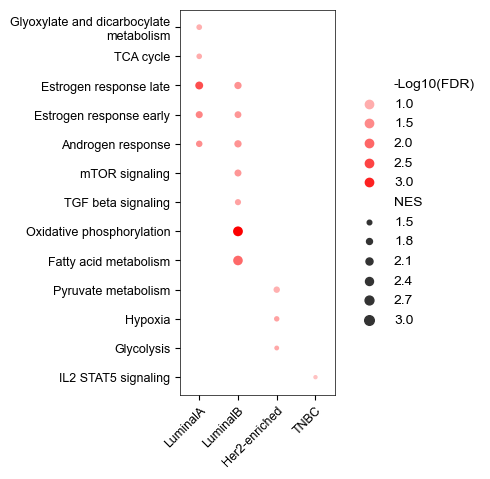

In [22]:
# Figure 5B

idc_subtype_gsea = pd.read_csv('../document/IDC_subtype_GSEA.csv')
idc_subtype_gsea['FDR'] = -np.log10(idc_subtype_gsea['FDR'])
idc_subtype_gsea['NES'] = idc_subtype_gsea['NES']
idc_subtype_gsea = idc_subtype_gsea.rename(columns={'FDR': '-Log10(FDR)'})
ax = scatterplot(idc_subtype_gsea, figsize=(2, 5), spines_hide=[], ticklabels_format=[], ticklabels_hide=[], labels_hide=['x', 'y'], palette=cmap_red, wrap_length=30, sizes=(10, 50))
ax.set_xlim([-.5, 3.5])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, rotation_mode='anchor', ha='right')
ax.get_figure().savefig('../figure/fig5/figure5B_bubbleplot.pdf', bbox_inches='tight')

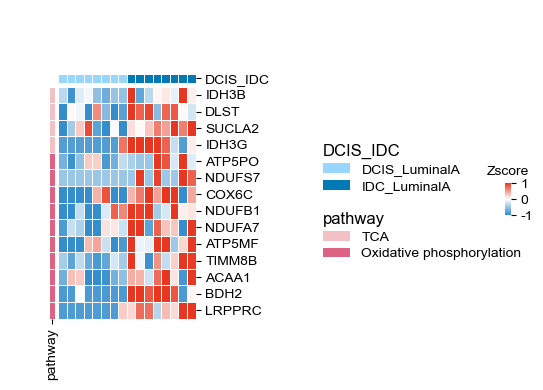

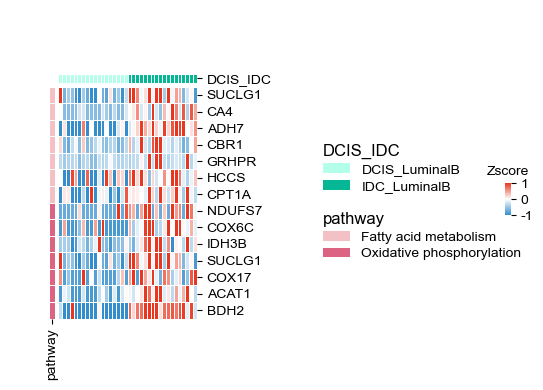

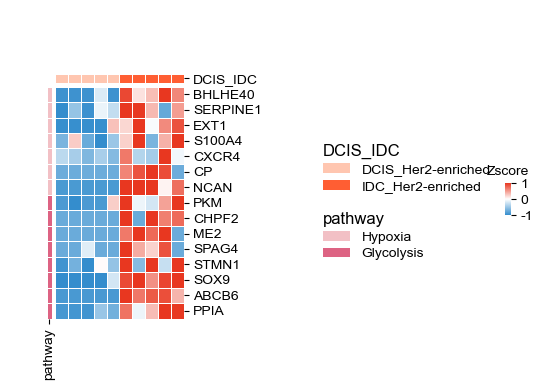

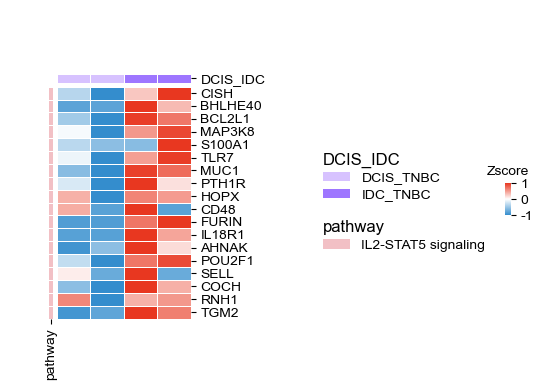

In [23]:
# Figure 5C, Supplementary Table 6A, 6B, 6C, and 6D

dcis_idc_proteins = pd.read_csv('../document/DCIS_IDC_proteins.csv', index_col=[0, 1])

palette = ['#f2c0c5', '#dd6383']
out_table_names = list('ABCD')
for subtype, out_table_name in zip(order_, out_table_names):
    tmp = combine(clinical.sort_values(by='ID'), pro, 'DCIS_IDC', dcis_idc_proteins.loc[subtype, 'protein'].values.tolist(), part_element=['DCIS_'+subtype, 'IDC_'+subtype]).droplevel(0).sort_index().T
    subtype_table = group_table(tmp.T).rename_axis('Gene Symbol')
    out_table = subtype_table.iloc[:, [0, 1, 2, 4]]
    plotdata = pd.concat([tmp, dcis_idc_proteins.loc[subtype].reset_index().set_index('protein')], axis=1).rename_axis('proteins').set_index('pathway', append=True).rename_axis('DCIS_IDC', axis=1)
    pathways = plotdata.index.get_level_values(1).unique()
    fig = heatmap(plotdata, lut={'DCIS_IDC': {k: v for k, v in dict(zip(matched_order_, matched_palette)).items() if subtype in k}, 'pathway': dict(zip(pathways.tolist(), palette[:len(pathways)]))}, z_score=0, cmap=cmap, yticklabels=plotdata.index.get_level_values(0), cbar_pos=(1.7, .45, .02, .08), figsize=(3, 4), linecolor='white', linewidth=.5)
    fig.ax_cbar.set_title('Zscore', fontsize=10)
    fig.savefig('../figure/fig5/figure5C_{}_heatmap.pdf'.format(subtype), bbox_inches='tight')

    out_table.iloc[:, 2] = 1 / out_table.iloc[:, 2]
    out_table.columns = ['DCIS {} mean'.format(subtype), 'IDC {} mean'.format(subtype), 'FC(IDC {} vs. DCIS {})'.format(subtype, subtype), 'ranksums p value']
    if subtype == 'TNBC':
        out_table = out_table.drop(out_table.columns[-1], axis=1)
    out_table.to_csv('../documents/fig5/Supplementary_Table_6{}.csv'.format(out_table_name))